# Load Save (Vanilla)

In [2]:
savename = "c:/Users/paulj/Desktop/prosjekt/pom_cpu-model/results/vanilla15_2025-02-12__14_27_42"
number=15

| **Parameter**                | **Value**      |
|------------------------------|----------------|
| Reward function type         | OpenPOM        |
| Similarity measure           | Cosine         |
| Graph building               | Fragments Vanilla      |
| Iterations                   | 500            |
| Max number of nodes          | 6              |
| Illegal action logreward     | -100           |
| β                            | 1             |
| Large molecule penalty       | None           |



## Imports

In [3]:
import sys
import os
path_to_top_dir = "../"
# Dynamically add the `project` directory to the path
sys.path.append(os.path.abspath(path_to_top_dir))

In [4]:
# Utils
import warnings

# Plotting
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import seaborn as sns
from pycirclize import Circos

# File management
import json
import numpy as np
import pandas as pd


# GFlowNET
import gflownet
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.config import init_empty, Config
from scent_gfn.molecule_test import MoleculeTask as MoleculeTaskTest
from scent_gfn.molecule_train import MoleculeTask 

# OpenPOM
from pom_models.functions import fragance_propabilities_from_smiles_test, fragance_propabilities_from_smiles_train

# Others
from tensorboard.backend.event_processing import event_accumulator
import torch
from rdkit import Chem





Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'
c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

In [5]:
fragance_propabilities_from_smiles = lambda smiles: fragance_propabilities_from_smiles_train(smiles)

## Functions

In [6]:
def get_fragrance_notes():
    return list(pd.read_csv("../data/data.csv").keys()[2:])

In [7]:
def get_sorted_targed_scent_indicies(target):
    return np.argsort(-np.array(target))

In [8]:
def get_evaluated_objs_notes_df(objs):
    labels= get_fragrance_notes()
    data_lst  = []
    for i, obj in enumerate(objs):
        smiles = Chem.MolToSmiles(obj)
        probs = fragance_propabilities_from_smiles(smiles)[0]

        data_lst.append( [smiles] + list(probs))
    result_df = pd.DataFrame(
        data=data_lst,
        index=[i for i in range(len(data_lst))],
        columns=["smiles"]+list(labels)
        )
    return result_df


In [9]:
def get_target_notes_df(target):
    labels= get_fragrance_notes()
    target_df = pd.DataFrame(
        data=[["target"] + list(target)],
        columns=["smiles"]+list(labels),
        index=["Target"]
    )
    return target_df

In [10]:
def get_most_important_indicies(number,target):
    labels= get_fragrance_notes()
    indices=get_sorted_targed_scent_indicies(target)
    most_important_indicies = indices[:number]
    most_important_keys = []
    for i in most_important_indicies:
        most_important_keys.append(labels[i])
    return most_important_keys

In [11]:
def get_plot_df(objs,target, number,rewards):
    result_df = get_evaluated_objs_notes_df(objs)
    most_important_keys = get_most_important_indicies(number,target)
    return result_df[most_important_keys].set_index(pd.Series([f"{i+1} r:{rewards[i]:.2f}" for i in range(len(result_df["smiles"]))]))

In [12]:
def create_radar_grid_plot(objs,target, number,rewards,dim=[5,5], space=[1,0.25]):
    
    plot_df = get_plot_df(objs,target, number,rewards)
    plot_target_df= get_target_notes_df(target)[get_most_important_indicies(number,target)]
    #print(plot_df)
    #print(plot_target_df)
    # Create 5 x 5 subplots
    fig = plt.figure(figsize=(26, 16), dpi=100)
    fig.subplots(dim[0], dim[1], subplot_kw=dict(polar=True))
    fig.subplots_adjust(wspace=space[0], hspace=space[1])
    # Plot radar chart into subplots for each target
    for target_name, ax in zip(plot_df.index, fig.axes):
        target_df = plot_df.loc[[target_name]]
        target_df = pd.concat([target_df, plot_target_df])
        # Initialize Circos instance for radar chart plot
        circos = Circos.radar_chart(
            target_df,
            vmax=1,
            marker_size=6,
            #cmap=dict(Hero="salmon", Warrior="skyblue", Wizard="lime", Assassin="magenta"),
            grid_interval_ratio=0.2,
            line_kws_handler=lambda _: dict(lw=2, ls="solid"),
            marker_kws_handler=lambda _: dict(marker="D", ec="grey", lw=0.5),
        )

        # Plot figure & set legend on upper right
        circos.plotfig(ax=ax)
        circos.ax.legend(loc="upper right", fontsize=10,bbox_to_anchor=(1.7, 1.1))
    return fig

In [13]:
def read_pine_smiles():
    return list(pd.read_csv("../data/intensities.csv")["smiles"])

In [14]:
def read_vanilla_smiles():
    df = pd.read_csv("../data/data.csv")
    vanilla_mols_df = df.loc[df['vanilla'] == 1]
    vanilla_smiles_trainig= list(vanilla_mols_df["nonStereoSMILES"])
    
    return vanilla_smiles_trainig

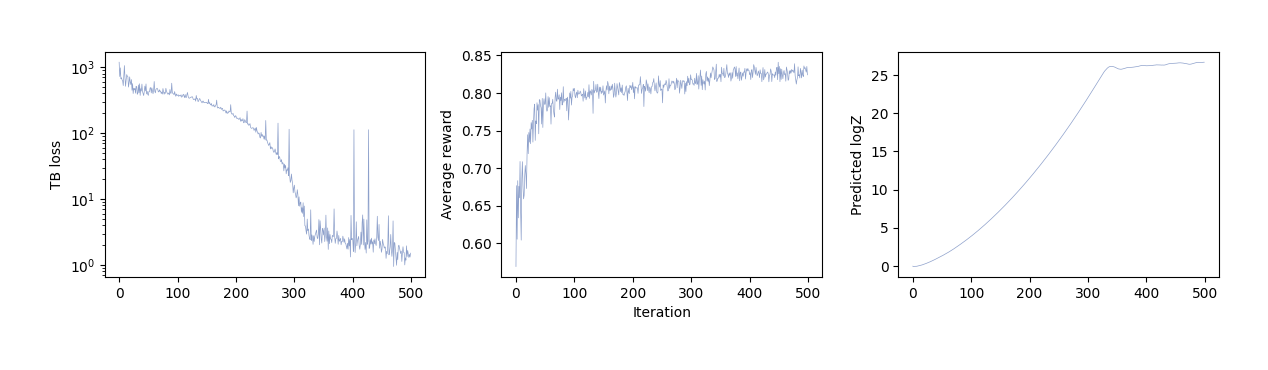

In [15]:

cfg = init_empty(Config())

cfg.log_dir = savename
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()


f, ax = plt.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')], color=sns.color_palette("Set2")[2])
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')], color=sns.color_palette("Set2")[2])
ax[1].set_ylabel('Average reward')
ax[1].set_xlabel('Iteration')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')], color=sns.color_palette("Set2")[2])
ax[2].set_ylabel('Predicted logZ')
plt.tight_layout()

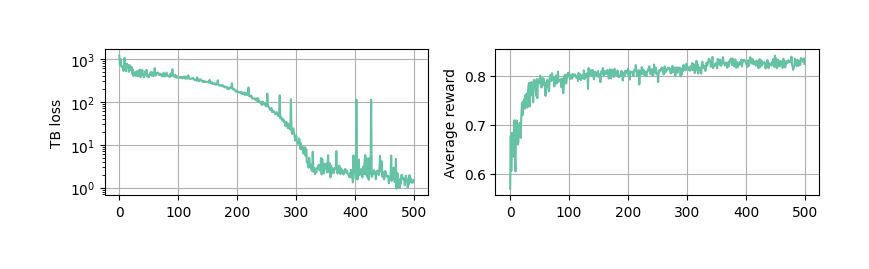

In [16]:
f, ax = plt.subplots(1, 2, figsize=(4*2,2))
ax[0].plot([i.value for i in ea.Scalars('train_loss')], color=sns.color_palette("Set2")[0], linewidth=1.5)
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[0].grid()
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')], color=sns.color_palette("Set2")[0], linewidth=1.5)
ax[1].set_ylabel('Average reward')
ax[1].grid()
#ax[1].set_xlabel('Iteration')
plt.tight_layout()
plt.savefig(f"../images/vanilla_{number}_plots.pdf", bbox_inches="tight")

In [18]:
# Model class must be defined somewhere
state = torch.load(os.path.join(cfg.log_dir, "model_final_save.pt"), weights_only=False)
#model = statemodel.eval()
#state["models_state_dict"]
config = state["cfg"]
env_ctx = state["env_ctx"]

In [19]:
with open(os.path.join(cfg.log_dir, "params.json"), "r") as file:
    params = json.load(file)

with open(os.path.join(cfg.log_dir, "target.json"), "r") as file:
    target = json.load(file)


In [20]:
model = gflownet.models.graph_transformer.GraphTransformerGFN(state["env_ctx"],state["cfg"])
model.load_state_dict(state["models_state_dict"][0])
model.eval()
1

1

In [19]:
#D:\Dokumenter\Skole\Prosjektoppgave\gflownet\src\gflownet\algo\trajectory_balance.py


algo = TrajectoryBalance(GraphBuildingEnv(),state["env_ctx"],state["cfg"])

In [20]:
task = MoleculeTask(data_tuple=(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]))

SMILES input data detected ...
Reward function: reward_function_openpom | Similarity measure: cosine_similarity | exp_penalty: False | max_mol=None


In [21]:
task_test = MoleculeTaskTest(data_tuple=(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]))

SMILES input data detected ...
Reward function: reward_function_openpom | Similarity measure: cosine_similarity | exp_penalty: False | max_mol=None


In [22]:
trajs = algo.create_training_data_from_own_samples(model, 12)

tensor([True, True, True, True, True, True, True, True, True, True, True, True])


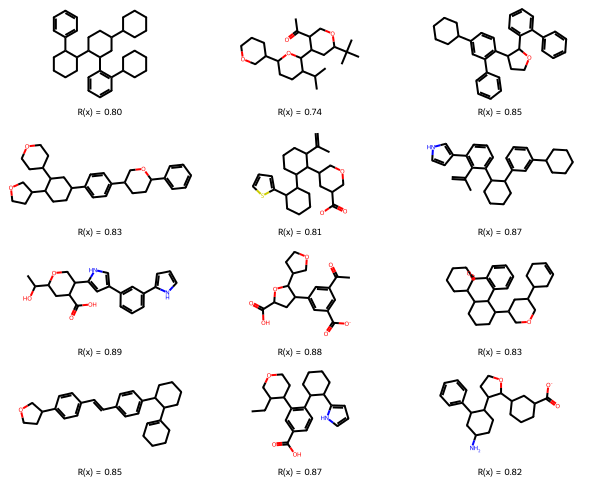

In [23]:
objs = [env_ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = task.compute_obj_properties(objs)
print(is_valid)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(obj_props))*params["beta"]}, obj_props)
index = 0
rewards = []

for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index].exp().item())
        index += 1 
    else:
        rewards.append(0.0)

MolsToGridImage(objs, molsPerRow=3, subImgSize=(200, 120), legends=[f'R(x) = {r:.2f}' for r in rewards])

In [29]:
task_test==task

False

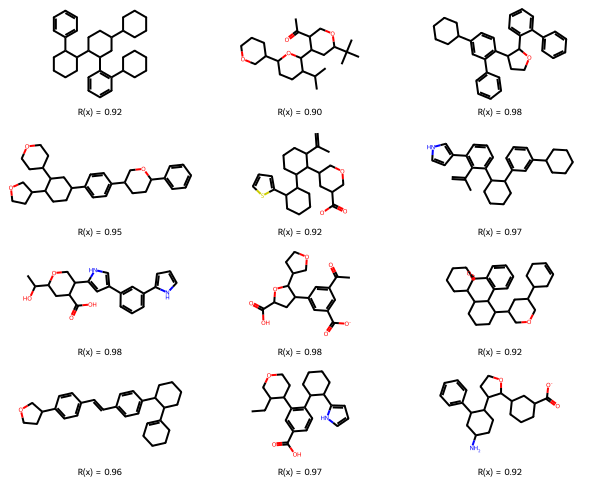

In [31]:
obj_props, is_valid = task_test.compute_obj_properties(objs)
log_rewards = task_test.cond_info_to_logreward({'beta': torch.ones(len(obj_props))*params["beta"]}, obj_props)
index = 0
rewards = []

for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index].exp().item())
        index += 1 
    else:
        rewards.append(0.0)

MolsToGridImage(objs, molsPerRow=3, subImgSize=(200, 120), legends=[f'R(x) = {r:.2f}' for r in rewards])

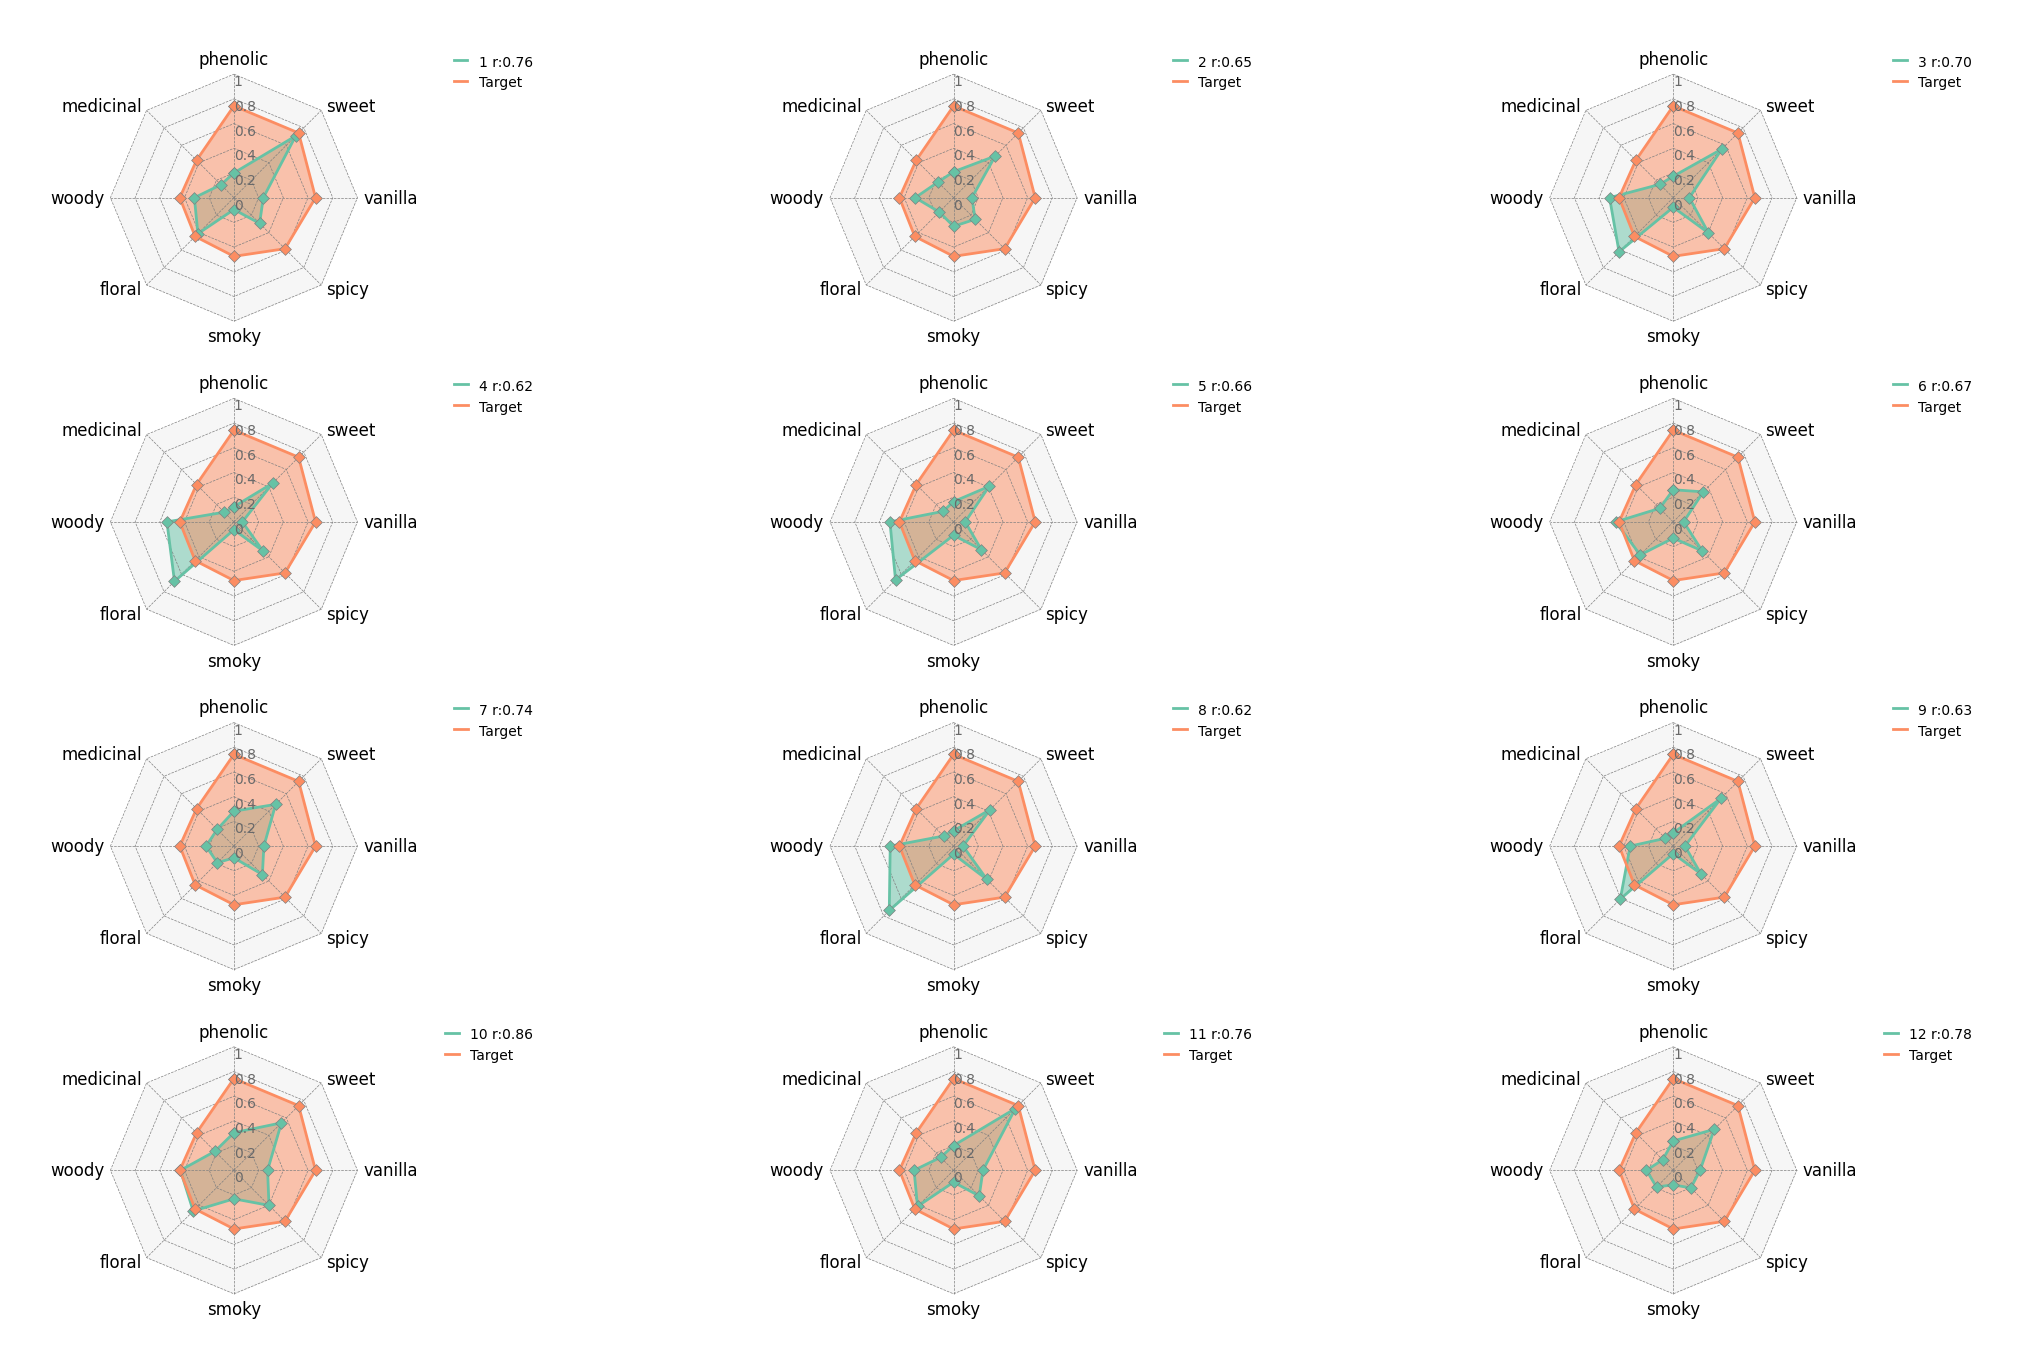

In [22]:
fig = create_radar_grid_plot(objs,fragance_propabilities_from_smiles(target[0])[0], 8,rewards,dim=[4,3],space=[0.25,0.25])

In [23]:
smiles = [Chem.MolToSmiles(m) for m in objs]


In [24]:
smiles

['CC(=O)CCC(C)=O',
 'CC(C)C',
 'CC(=O)C=C(C)C(C)(C)C',
 'CC(C=CC(C)(C)C)=CC(C)(C)C',
 'CC(C)(O)CCC1CC1',
 'CC(C)(C)C(C)(C)O',
 'CC=O',
 'CC(C)=CC1CC1',
 'CC(=O)CCCCCCC=C(C)C',
 'CC(=O)c1c[nH]c(C(C)(C)C)c1',
 'CC(=O)CCC(C)=O',
 'CC(=CC(C)O)C(C)O']

In [25]:
#objs = [Chem.MolFromSmiles(s) for s in smiles]

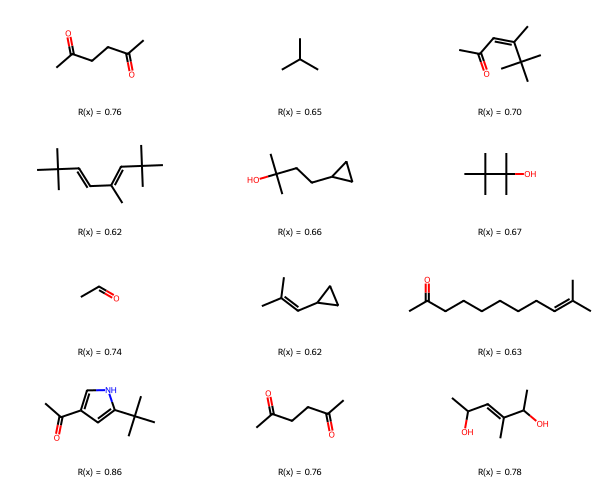

In [25]:
obj_props, is_valid = task.compute_obj_properties(objs)
rewards=[task.reward_function(o) for o in objs]

MolsToGridImage(objs, molsPerRow=3, subImgSize=(200, 120), legends=[f'R(x) = {r:.2f}' for r in rewards])

In [26]:



largest_indices = np.argsort(np.array(rewards))[-4:][::-1]
reduced_mols =[]
reduced_rewards = []
for i in largest_indices:
    reduced_mols.append(objs[i])
    reduced_rewards.append(rewards[i])
reduced_mols,reduced_rewards

([<rdkit.Chem.rdchem.Mol at 0x213b0dbe340>,
 [0.8649241, 0.77632385, 0.760876, 0.760876])

In [27]:
smiles_list = [Chem.MolToSmiles(m) for m in reduced_mols]
smiles_list

['CC(=O)c1c[nH]c(C(C)(C)C)c1',
 'CC(=CC(C)O)C(C)O',
 'CC(=O)CCC(C)=O',
 'CC(=O)CCC(C)=O']

gen_mol_images("van8", smiles_list8, rewards8, size=(7*200,7*120), bond_width=6)

In [28]:
def create_radar_plots_set(objs,target, number,rewards,dirname, space=[1,0.25], bbox=[1.7,1.1], fsize=10,grid_label_formatter=None,label_kws_handler=None,grid_label_kws = None):
    
    plot_df = get_plot_df(objs,target, number,rewards)
    plot_target_df= get_target_notes_df(target)[get_most_important_indicies(number,target)]
    #print(plot_df)
    #print(plot_df)
    #print(plot_target_df)
    # Create 5 x 5 subplots
    #fig = plt.figure(figsize=(26, 16), dpi=100)
    #fig.subplots(dim[0], dim[1], subplot_kw=dict(polar=True))
    #fig.subplots_adjust(wspace=space[0], hspace=space[1])
    # Plot radar chart into subplots for each target
    for i, target_name in enumerate(plot_df.index):
        target_df = plot_df.loc[[target_name]]
        reward_val=target_df.index[0].split(":")[1]
        target_df.index = ["Molecule"]
        target_df = pd.concat([target_df, plot_target_df])
        # Initialize Circos instance for radar chart plot
        circos = Circos.radar_chart(
            target_df,
            vmax=1,
            marker_size=6,
            #cmap=dict(Hero="salmon", Warrior="skyblue", Wizard="lime", Assassin="magenta"),
            grid_interval_ratio=0.2,
            line_kws_handler=lambda _: dict(lw=2, ls="solid"),
            marker_kws_handler=lambda _: dict(marker="D", ec="grey", lw=0.5),
            grid_label_formatter=grid_label_formatter,
            label_kws_handler=label_kws_handler,
            grid_label_kws = grid_label_kws,
        )

        # Plot figure & set legend on upper right
        fig = circos.plotfig(figsize=(13, 8), dpi=100)
        circos.ax.legend(loc="upper right", fontsize=fsize,bbox_to_anchor=(bbox[0], bbox[1]))
        plt.savefig(f"../images/{dirname}/radar{i}r{reward_val}.pdf", bbox_inches="tight")
    return fig

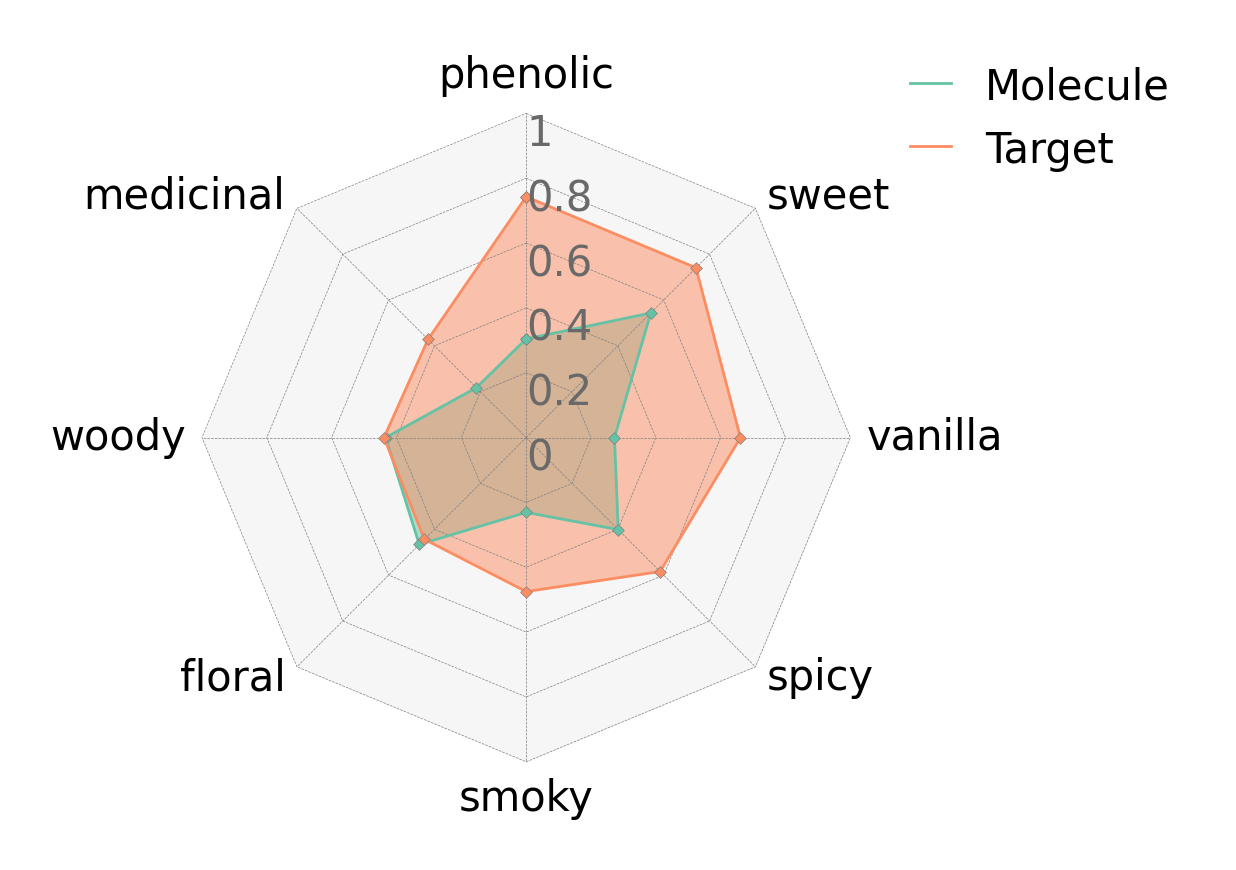

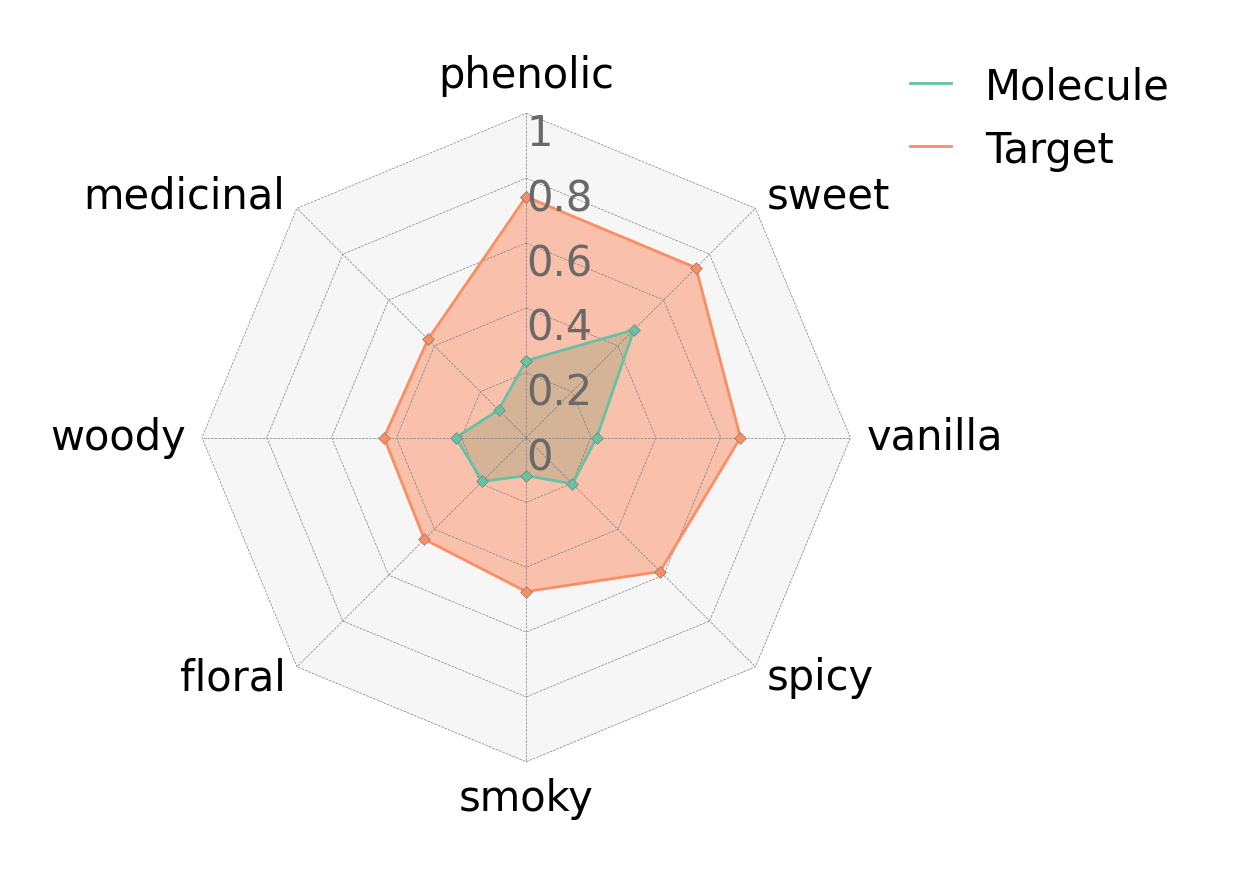

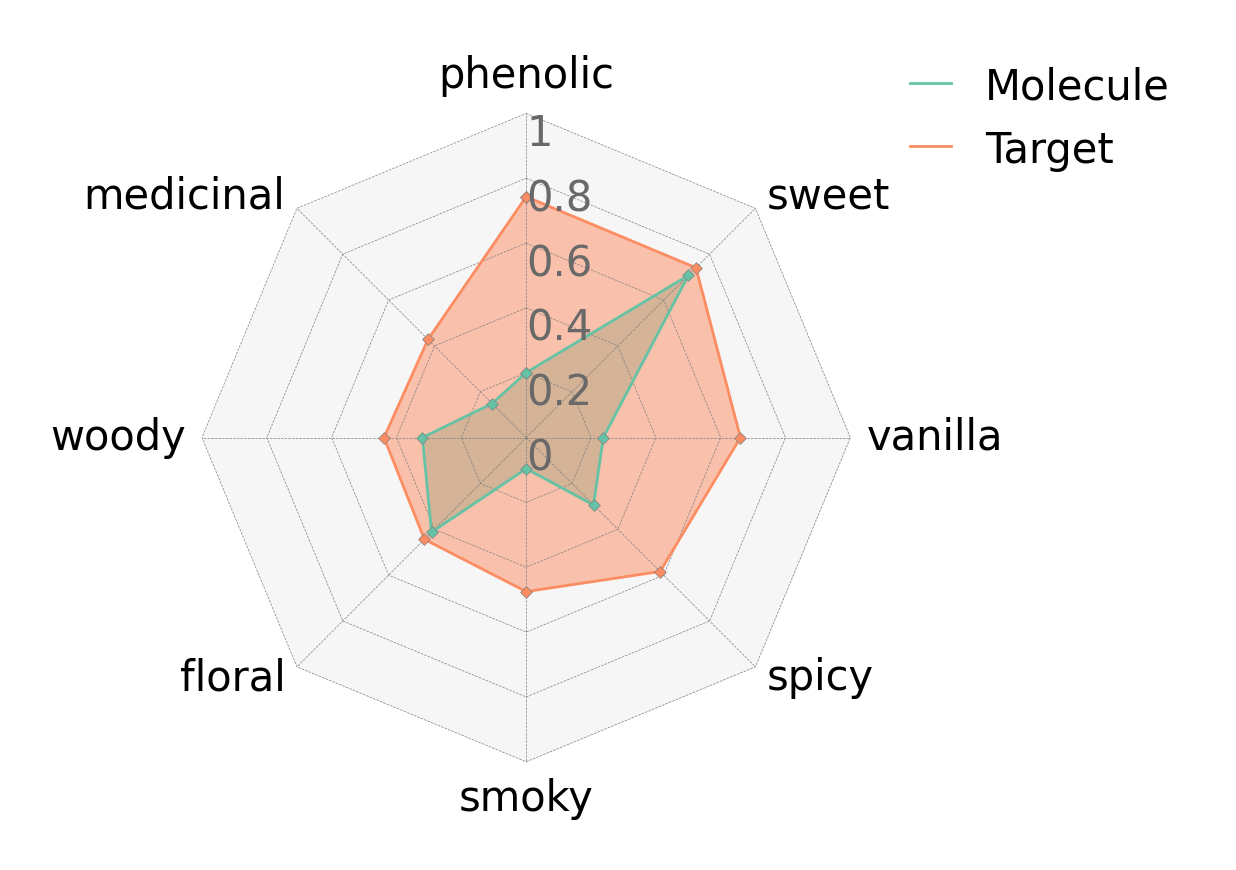

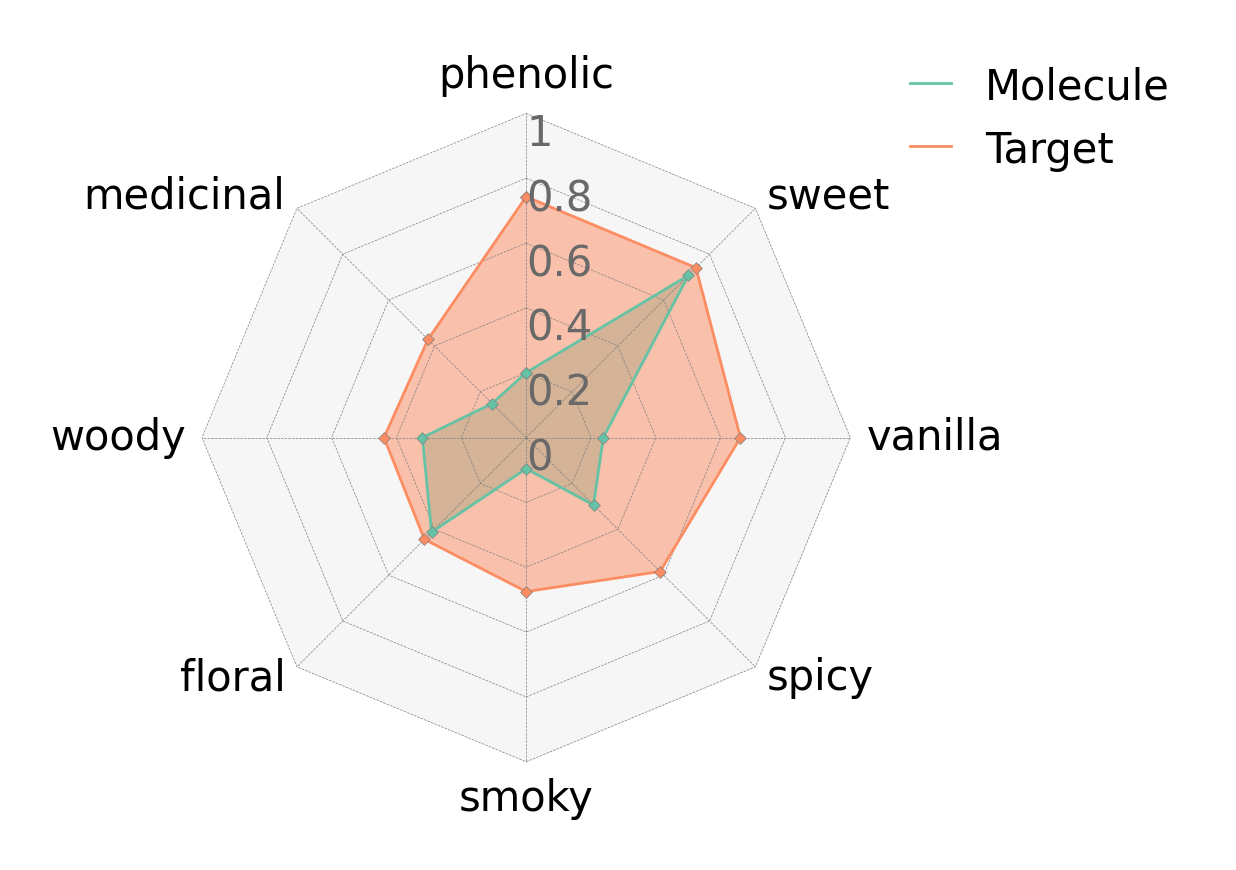

In [29]:
fsize=30
fig = create_radar_plots_set(
    reduced_mols,
    fragance_propabilities_from_smiles(target[0])[0], 
    8,
    reduced_rewards,
    f"van{number}",
    space=[0.01,0.4], 
    fsize=fsize, 
    bbox=[1.5,1.1], 
    label_kws_handler=lambda _: dict(size=fsize),
    grid_label_kws=dict(size=fsize),
    )

In [30]:
trajs1000 = algo.create_training_data_from_own_samples(model, 1000)

In [31]:
objs1000 = [env_ctx.graph_to_obj(i['result']) for i in trajs1000]

In [35]:
rewards1000 = [task.reward_function(o) for o in objs1000]

In [32]:

vanilla_data = [Chem.MolFromSmiles(s) for s in read_vanilla_smiles()]

# Generate canonical SMILES for comparison
objs1000_smiles_canon = [Chem.MolToSmiles(mol, canonical=True) for mol in objs1000]
vanilla_smiles_canon = [Chem.MolToSmiles(mol, canonical=True) for mol in vanilla_data]

# Check if molecules in list1 are in list2
contained_in_both = []
for smiles in vanilla_smiles_canon:
        if smiles in objs1000_smiles_canon:
            contained_in_both.append(smiles)

contained_in_both


[]

In [40]:
indiciestop20= []
for i in sorted(rewards1000, reverse=True)[:20]:
    indiciestop20.append(rewards1000.index(i))
indiciestop20

[319,
 440,
 492,
 430,
 556,
 216,
 291,
 527,
 244,
 224,
 408,
 498,
 818,
 611,
 594,
 614,
 253,
 973,
 255,
 255]

In [41]:
smilestop20 = []
for i in indiciestop20:
    smilestop20.append(objs1000_smiles_canon[i])
smilestop20

['CCc1c[nH]c(C(C)=O)c1',
 'C=Cc1c[nH]c(C(C)=O)c1',
 'CC(=O)c1c[nH]c(C(C)O)c1',
 'CC(=O)C=Cc1cc(C(C)=O)c[nH]1',
 'CC(=O)c1c[nH]c(-c2cc(C=C(C)C)c[nH]2)c1',
 'CC(=O)C=C(C)c1cc(C(C)O)c[nH]1',
 'CC(=O)CCc1cc(C(C)=O)c[nH]1',
 'CC(=O)c1cc(CCC(C)O)c[nH]1',
 'CC(=O)C(C)=Cc1cc(C(C)=O)c[nH]1',
 'CC(=O)c1cc(CCc2cc(C(C)O)c[nH]2)c[nH]1',
 'CC(C)=Cc1cc(C(C)O)c[nH]1',
 'CC=Cc1ccc[nH]1',
 'CC(C)=Cc1cc(C=CC(C)O)c[nH]1',
 'CC(=O)c1c[nH]c(C2CC2)c1',
 'CC(C)(O)c1c[nH]c(C=O)c1',
 'CC(=O)C=CC=O',
 'CCc1cc[nH]c1',
 'CC(=O)C=C(C)c1c[nH]c(C2CC2)c1',
 'CC(=O)C=CC(C)=O',
 'CC(=O)C=CC(C)=O']

In [36]:
rewards1000

[0.7364088,
 0.66841143,
 0.6398073,
 0.8034371,
 0.63333017,
 0.8064093,
 0.6612006,
 0.7024846,
 0.6395563,
 0.6548089,
 0.7364088,
 0.8159037,
 0.6344056,
 0.62485355,
 0.81234443,
 0.5997207,
 0.69207704,
 0.6614258,
 0.650696,
 0.65342844,
 0.6616291,
 0.636308,
 0.7510574,
 0.6612006,
 0.6300068,
 0.7575056,
 0.65538824,
 0.712935,
 0.651473,
 0.84384656,
 0.7441299,
 0.6398073,
 0.7425937,
 0.81234443,
 0.7878818,
 0.8398003,
 0.78874403,
 0.64590204,
 0.71707475,
 0.6684185,
 0.67514586,
 0.5997207,
 0.6785962,
 0.69787514,
 0.5300307,
 0.6288166,
 0.61644834,
 0.64590204,
 0.59811497,
 0.63333017,
 0.65761536,
 0.78610533,
 0.63505036,
 0.6795182,
 0.7024846,
 0.6570255,
 0.6958158,
 0.72593665,
 0.78610533,
 0.81265503,
 0.6612006,
 0.6612006,
 0.7046734,
 0.72165895,
 0.6594859,
 0.75306755,
 0.6809917,
 0.68269396,
 0.7107172,
 0.53996336,
 0.8331633,
 0.6288893,
 0.6956203,
 0.6331545,
 0.7013184,
 0.8064093,
 0.6895756,
 0.64590204,
 0.6086283,
 0.8064093,
 0.75173026,
 0

In [34]:
objs1000_smiles_canon

['CC(O)C(C)(C)O',
 'CCC1CC1',
 'CC(C)=CC(C)=CC(C)(C)C',
 'CC(=O)CCC(C)O',
 'CC(=O)C=CC=CCCC=C(C)C',
 'CC(=O)C1CC1',
 'CC(C)=CC(C)(C)C',
 'CC(=O)CCC=C(C)C',
 'CC(=CC(C)(C)C)C1CC1',
 'CC(=O)CCCCC=C(C)C',
 'CC(O)C(C)(C)O',
 'CC(=O)C=CC(C)(C)O',
 'CC(=CCCC(C)(C)O)C(C)(C)C',
 'CC(C)=CC1CC1',
 'CC(C)=CC(C)O',
 'CC',
 'CC(=O)C=C(C)C=CC(C)=CC=C(C)C',
 'CC(=O)CCC=CC=C(C)C',
 'C=C(C)C=C(C)C(C)(C)C',
 'CC(C)(C)C(C)(C)C',
 'CC(C)(O)C=CCCC=CC(C)(C)O',
 'CC(C)=CCCC(C)(C)C',
 'CC(=O)C=CC=C(C)CCC(C)=O',
 'CC(C)=CC(C)(C)C',
 'CC(C)(O)C=CCCC1CC1',
 'CC(=O)C=CC(C)=CC(C)(C)O',
 'CC(C)=CCCC(C)(C)O',
 'CC(O)C=CC(C)(C)C',
 'CC(C)C',
 'C=CC(C)=O',
 'CC=O',
 'CC(C)=CC(C)=CC(C)(C)C',
 'CC(O)C1CC1',
 'CC(C)=CC(C)O',
 'CC(=O)CCC=CC(C)O',
 'CC(=O)C=CC(C)=CC(C)O',
 'CC(=O)C=CCCC(C)=O',
 'CC(C)(C)C1CC1',
 'CCC(C)O',
 'CC(C)=CC=CC=CC(C)O',
 'CC(C)=CC=C(C)C',
 'CC',
 'CC(C)(O)C1CC1',
 'CC(=O)CCCCC(C)(C)O',
 'C=C',
 'CCCC',
 'CC(C=CC(C)(C)C)=CC(C)(C)C',
 'CC(C)(C)C1CC1',
 'CC(C)=CC=C(C)C=CCCC(C)(C)C',
 'CC(=O)C=CC=CCCC